# Exploratory Data Analysis (EDA)
This section presents the exploratory data analysis (EDA) conducted to understand the characteristics of the electricity load dataset. The objective is to identify temporal consumption patterns, assess data quality, detect anomalies, and derive insights relevant for subsequent forecasting model development.

In [2]:
# imports
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

## Loading the data

In [3]:
# Define the Paths for loading the data
interim_folder = "../data/interim"

# Load the CSV with the data for all years
cleaned_df = pd.read_csv(os.path.join(interim_folder, "cleaned_df.csv"), sep=';', decimal=',')

# Take a quick look at the data
cleaned_df.head(3)

,timestamp,load_MWh
0,2021-01-01 00:00:00,44569.25
1,2021-01-01 01:00:00,42806.00
2,2021-01-01 02:00:00,41049.75


## Datetime conversion and basic feature engineering
Convert the `timestamp` column to pandas datetime, then derive useful features such as `weekday`, `hour`, `month`, and `year`. These features are used for grouping and time-based analysis later in the notebook.

In [4]:
# Convert 'timestamp' column to datetime
cleaned_df["timestamp"] = pd.to_datetime(cleaned_df["timestamp"])
cleaned_df.head(3)

,timestamp,load_MWh
0,2021-01-01 00:00:00,44569.25
1,2021-01-01 01:00:00,42806.00
2,2021-01-01 02:00:00,41049.75


In [5]:
# Add weekday information
cleaned_df["weekday"] = cleaned_df["timestamp"].dt.day_name()
cleaned_df.head(3)

# Add month and year information
cleaned_df["month"] = cleaned_df["timestamp"].dt.month_name()
cleaned_df["month_num"] = cleaned_df["timestamp"].dt.month
cleaned_df["year"] = cleaned_df["timestamp"].dt.year

# Add hour information
cleaned_df["hour"] = cleaned_df["timestamp"].dt.hour
cleaned_df.head(3)

# Add day-of-year imformation
cleaned_df['day_of_year'] = cleaned_df['timestamp'].dt.dayofyear

# Add week-of-year information
cleaned_df['week_of_year'] = cleaned_df['timestamp'].dt.isocalendar().week


## Visualization of the Load Distribution

This visualization aims to examine the distribution of electricity load values by combining a histogram with a density curve and a boxplot. It provides insight into typical demand levels, overall variability, and the presence of extreme values, helping to understand the underlying structure and spread of electricity consumption.

count    35060.00
mean     54496.04
std       9568.89
min      30902.75
25%      46697.25
50%      54492.50
75%      61881.94
max      81319.50
Name: load_MWh, dtype: object


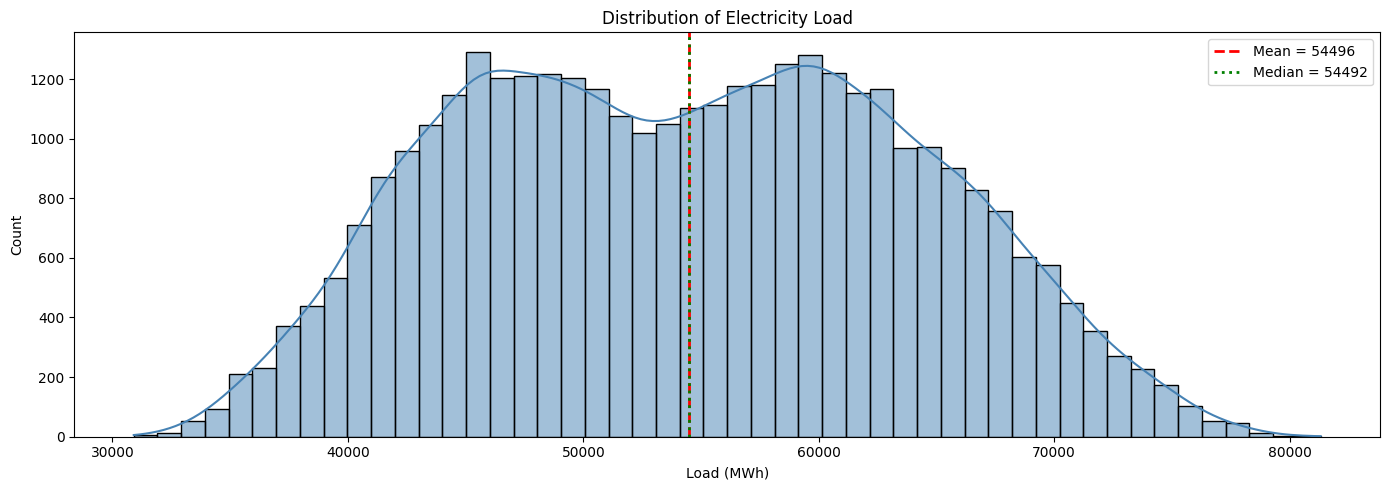

In [16]:
# Select data
data = cleaned_df["load_MWh"]

# Print summary stats
print(data.describe().apply(lambda x: f"{x:.2f}"))

# Create single histogram figure
plt.figure(figsize=(14, 5))

# Plot histogram with KDE
sns.histplot(data, bins=50, kde=True, color="steelblue")

# Statistics
mu = data.mean()
med = data.median()

# Lines for mean & median
plt.axvline(mu, color="red", linestyle="--", linewidth=2, label=f"Mean = {mu:.0f}")
plt.axvline(med, color="green", linestyle=":", linewidth=2, label=f"Median = {med:.0f}")

# Labels & title
plt.title("Distribution of Electricity Load")
plt.xlabel("Load (MWh)")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

### Key Findings: Load Distribution (2021–2024)

- The load distribution exhibits a bimodal pattern, reflecting distinct low-demand periods (e.g., summer months and nighttime hours) and high-demand periods (e.g., winter months and daytime hours).
- Mean and median values are nearly identical, indicating an overall symmetric distribution despite pronounced seasonal variation.
- The broad range of observed values highlights substantial variability in electricity demand across different times of the year.
- Elevated values and extended tails indicate occasional peak demand levels, particularly during winter periods or phases of increased industrial activity.



## Visualization of Yearly Patterns

This code compares electricity load patterns across years by plotting the full time-series for each year on the same chart. It visualizes how consumption evolves over time and highlights year-to-year differences. Summary statistics (mean and standard deviation per year) are displayed on the plot to support interpretation of annual load variability.

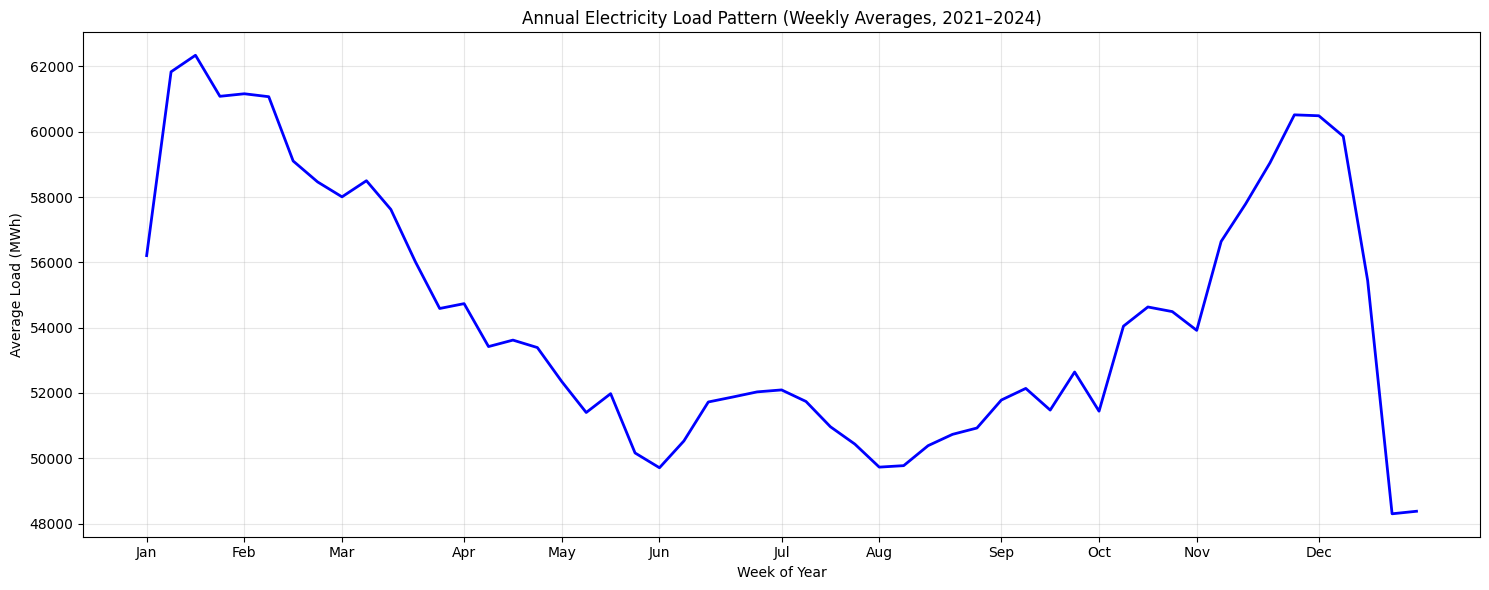

In [14]:
# Compute weekly average load across all years
df_weekly_agg = (
    cleaned_df
    .groupby('week_of_year')['load_MWh']
    .mean()
    .reset_index()
)

# Plot aggregated weekly curve
plt.figure(figsize=(15, 6))
plt.plot(
    df_weekly_agg['week_of_year'], 
    df_weekly_agg['load_MWh'], 
    color='blue', 
    linewidth=2
)

plt.title('Annual Electricity Load Pattern (Weekly Averages, 2021–2024)')
plt.xlabel('Week of Year')
plt.ylabel('Average Load (MWh)')
plt.grid(alpha=0.3)

plt.xticks(
    ticks=[1, 5, 9, 14, 18, 22, 27, 31, 36, 40, 44, 49],
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)

plt.tight_layout()
plt.show()

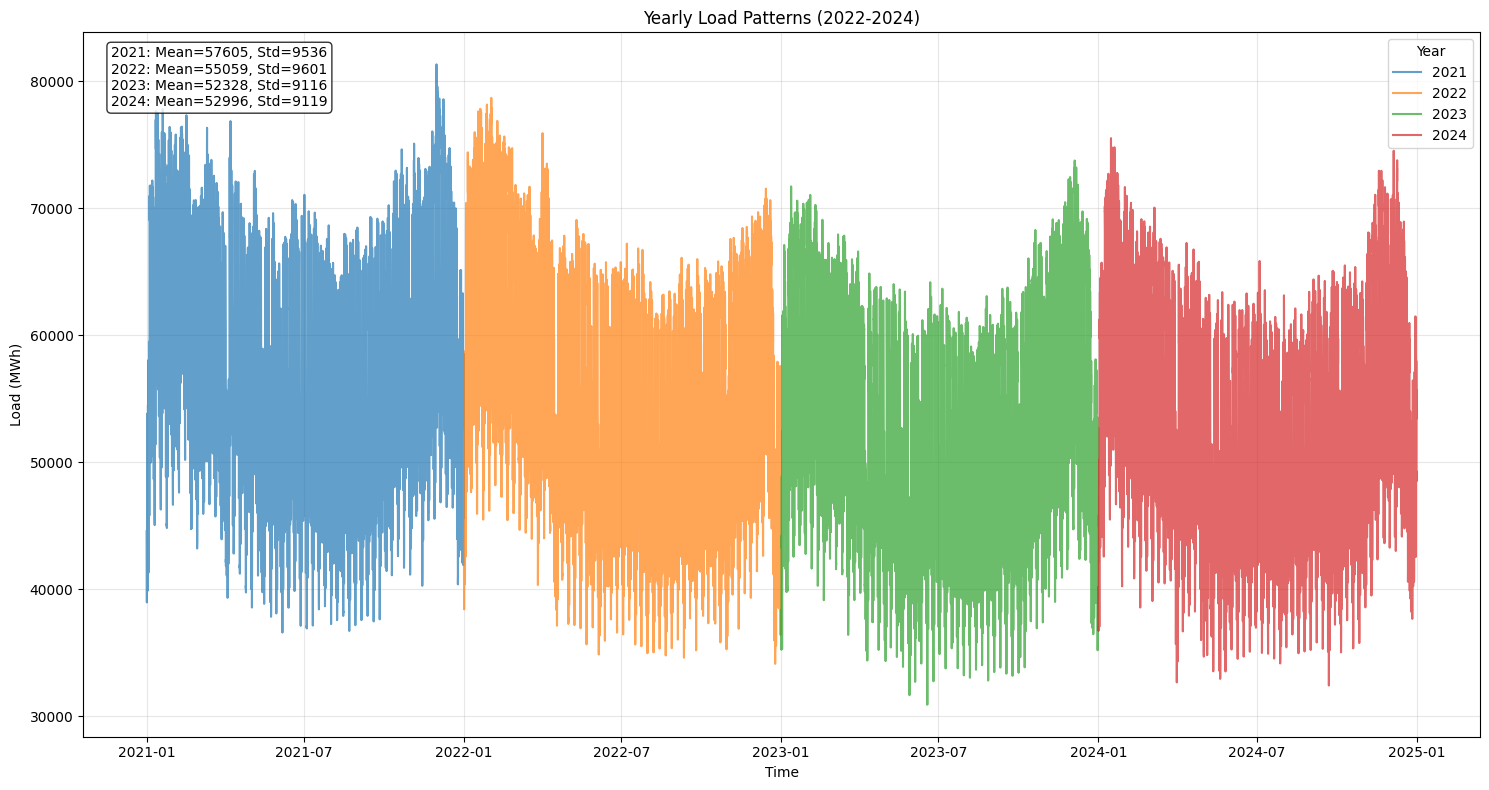

In [8]:
# Compute yearly summary statistics
summary_year = (
    cleaned_df.groupby("year")["load_MWh"]
    .agg(mean="mean", std="std")
)

# Create a figure
plt.figure(figsize=(15, 8))

# Plot yearly patterns
for year in cleaned_df['year'].unique():
    year_data = cleaned_df[cleaned_df['year'] == year]
    plt.plot(year_data['timestamp'], year_data['load_MWh'], 
             label=f'{year}', alpha=0.7)

# Customize the plot
plt.title('Yearly Load Patterns (2022-2024)', fontsize=12)
plt.xlabel('Time')
plt.ylabel('Load (MWh)')
plt.grid(True, alpha=0.3)
plt.legend(title='Year')

# Add summary statistics as text
textstr = '\n'.join([
    f"{year}: Mean={row['mean']:.0f}, Std={row['std']:.0f}"
    for year, row in summary_year.iterrows()
])
plt.text(0.02, 0.98, textstr, 
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


### Key Findings: Yearly Load Profile

- 2021 recorded the highest average load levels, marking the end of the post-pandemic rebound period with elevated industrial activity.
- 2022 shows a moderate decline in demand, reflecting the beginning of the energy crisis and initial efficiency measures.
- 2023 and 2024 maintain lower but stable consumption levels, indicating sustained energy-saving behavior and gradual market stabilization.
- A consistent seasonal pattern persists across all years, with pronounced winter peaks and summer troughs.
- Weekly-aggregated trends reveal a clear annual consumption cycle — a decline from winter to summer followed by a recovery toward winter.
- Lowest loads typically occur between weeks 25–35 (mid-summer), driven by reduced heating and industrial slowdowns.
- Highest loads occur between weeks 1–10 and 45–52, reflecting heating demand, shorter daylight hours, and peak industrial activity.


## Visualization of the Monthly Patterns

This code analyzes seasonal load patterns across multiple years. It calculates the average electricity load for each month of each year, then visualizes monthly load trends by plotting one line per year. This allows comparison of seasonal consumption cycles and highlights how monthly load levels may vary or shift over time.

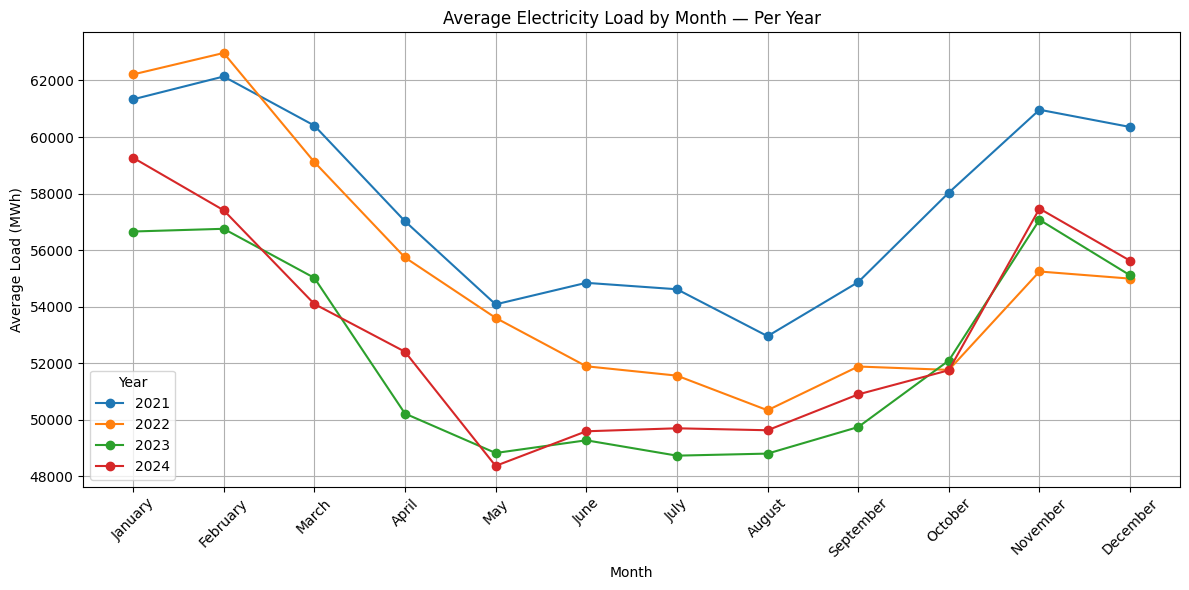

In [9]:
# Calculate mean load for each month per year
monthly_yearly = (
    cleaned_df
    .groupby(["year", "month_num", "month"])['load_MWh']
    .mean()
    .reset_index()
)

# Ensure months are ordered correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_yearly['month'] = pd.Categorical(monthly_yearly['month'], categories=month_order, ordered=True)
monthly_yearly = monthly_yearly.sort_values(['year', 'month_num'])

# Pivot so rows = month_num (1..12) and columns = years
pivot_yearly = monthly_yearly.pivot(index='month_num', columns='year', values='load_MWh')

# Plot one line per year
plt.figure(figsize=(12, 6))
for yr in pivot_yearly.columns:
    plt.plot(pivot_yearly.index, pivot_yearly[yr], marker='o', label=str(yr))

plt.xlabel("Month")
plt.ylabel("Average Load (MWh)")
plt.title("Average Electricity Load by Month — Per Year")
plt.grid(True)
plt.xticks(ticks=range(1,13), labels=month_order, rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


### Key Findings: Monthly Load Profile

- 2021 shows the highest monthly load levels, particularly in the winter and early spring months.
→ This reflects a strong post-pandemic industrial rebound and relatively high baseline consumption before the onset of the energy crisis.
- 2022 marks the beginning of a decline in electricity demand, with still elevated values in winter and spring.
→ The early months were influenced by gas-to-electricity substitution and heating demand following the start of the Ukraine war.
- 2023 and 2024 exhibit lower but stable load levels across most months, indicating persistent energy-saving behavior and efficiency improvements.
→ The consumption patterns of both years remain closely aligned, suggesting a stabilized demand environment.
- All years show a clear seasonal structure, with minimum loads during the summer months (June–August) and increasing consumption toward winter.
Slightly higher loads in autumn (October–November) in 2023 and 2024 may reflect the continued electrification of heating and cooler late-year periods.

## Visualization of the Weekly Patterns

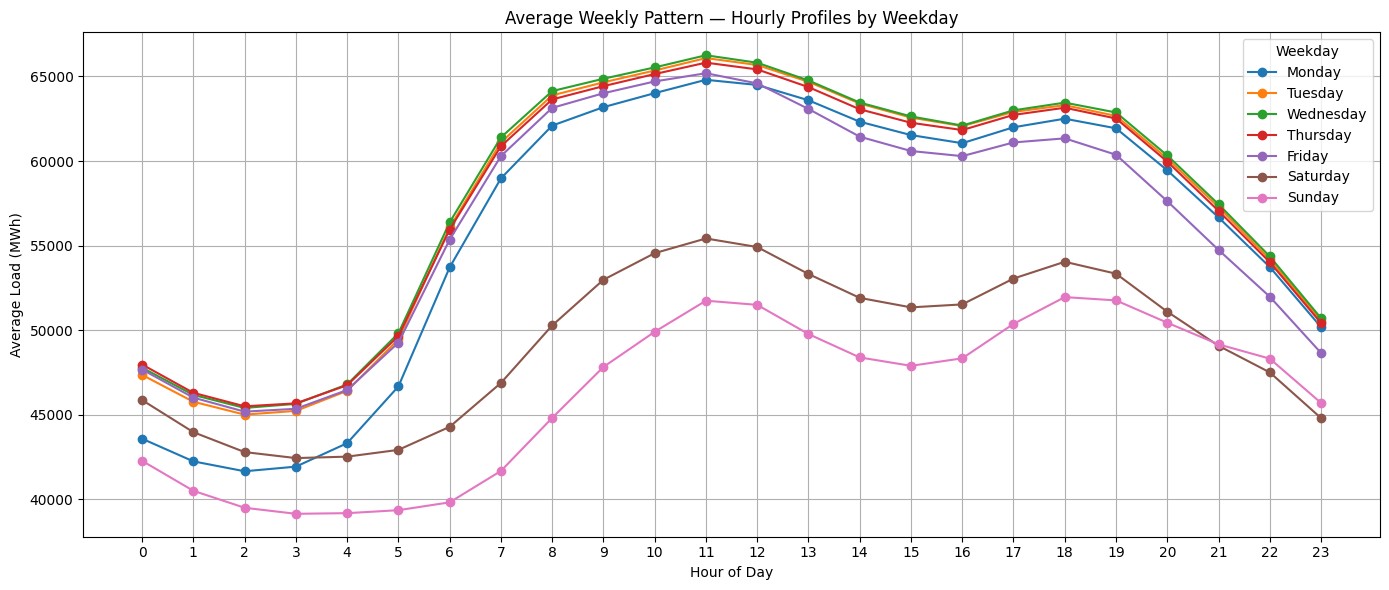

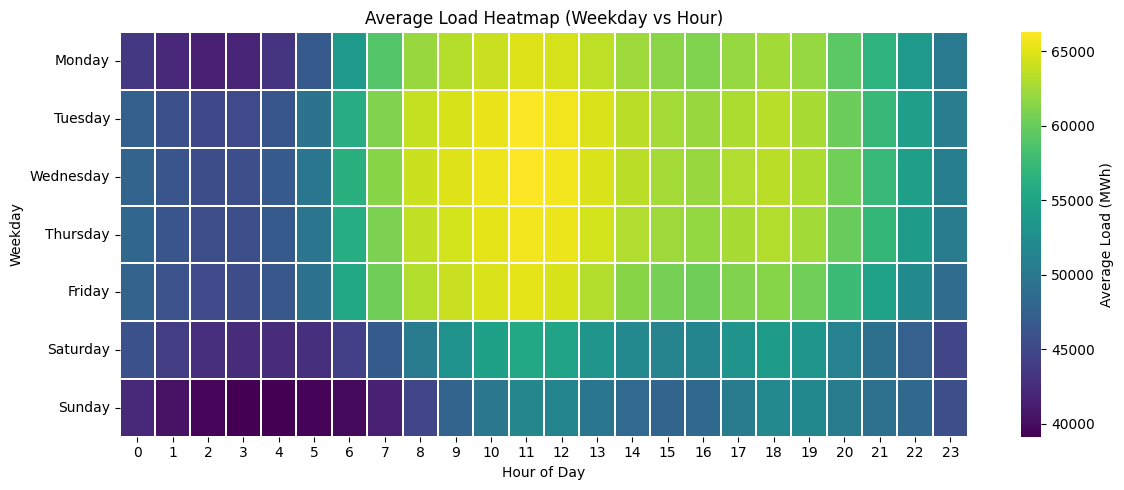

In [10]:
# Calculate mean load for each hour across all days
hourly_mean = cleaned_df.groupby("hour")["load_MWh"].mean().reset_index()

# Average weekly pattern (hourly profiles across weekdays)
# Ensure 'hour' column exists
if 'hour' not in cleaned_df.columns:
    cleaned_df['hour'] = cleaned_df['timestamp'].dt.hour

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Compute mean load per (weekday, hour)
weekly_hourly = (
    cleaned_df
    .groupby(['weekday', 'hour'])['load_MWh']
    .mean()
    .reset_index()
)

# Ensure correct weekday ordering and pivot to hours x weekdays
weekly_hourly['weekday'] = pd.Categorical(weekly_hourly['weekday'], categories=weekday_order, ordered=True)
weekly_hourly = weekly_hourly.sort_values(['weekday', 'hour'])

pivot_table = weekly_hourly.pivot(index='hour', columns='weekday', values='load_MWh')

# Line plot: one line per weekday across 24 hours
plt.figure(figsize=(14, 6))
for wd in weekday_order:
    if wd in pivot_table.columns:
        plt.plot(pivot_table.index, pivot_table[wd], marker='o', label=wd)

plt.xlabel('Hour of Day')
plt.ylabel('Average Load (MWh)')
plt.title('Average Weekly Pattern — Hourly Profiles by Weekday')
plt.xticks(range(24))
plt.grid(True)
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

# Heatmap: weekday (y) vs hour (x)
try:
    import seaborn as sns
except Exception:
    sns = None

if sns is not None:
    plt.figure(figsize=(12, 5))
    # transpose so rows = weekdays, cols = hours
    sns.heatmap(pivot_table.T, cmap='viridis', cbar_kws={'label': 'Average Load (MWh)'}, linewidths=0.3)
    plt.xlabel('Hour of Day')
    plt.ylabel('Weekday')
    plt.title('Average Load Heatmap (Weekday vs Hour)')
    # set x ticks to 0..23
    plt.xticks(ticks=np.arange(24)+0.5, labels=range(24), rotation=0)
    plt.tight_layout()
    plt.show()
else:
    # fallback: use imshow
    plt.figure(figsize=(12, 5))
    im = plt.imshow(pivot_table.T, aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Average Load (MWh)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Weekday')
    plt.title('Average Load Heatmap (Weekday vs Hour)')
    plt.xticks(ticks=np.arange(24), labels=range(24), rotation=0)
    plt.yticks(ticks=np.arange(len(pivot_table.columns)), labels=pivot_table.columns)
    plt.tight_layout()
    plt.show()


### Key Findings: Weekly Load Profile

- **Stable weekday–weekend split**  
  - Monday to Friday show consistently higher electricity demand than Saturday and Sunday.  
  - Weekend consumption remains lower and more uniform across all hours.

- **Morning ramp-up pattern**  
  - Load rises sharply between 6:00 and 8:00 as industrial, commercial, and public activity begins.  
  - This pattern is remarkably stable across all years.

- **Peak demand between 10:00 and 13:00**  
  - Highest weekday consumption occurs during late morning to early afternoon, especially mid-week (Wednesday and Thursday).  

- **Gradual evening decline**  
  - After around 17:00, demand steadily decreases, reflecting reduced business activity and tapering residential use.  

- **Friday transition effect**  
  - Slightly lower afternoon and evening consumption compared to mid-week, indicating earlier reductions in industrial output.  

- **Smoother weekend profiles**  
  - Saturday and Sunday exhibit flatter curves with smaller intra-day variations, dominated by residential consumption rather than industrial load.



## Visualization of the Daily Patterns

This code calculates the average electricity load for each hour of the day for the years 2022, 2023, and 2024, and then plots the hourly load profiles for each year on the same chart to compare daily consumption patterns across years.

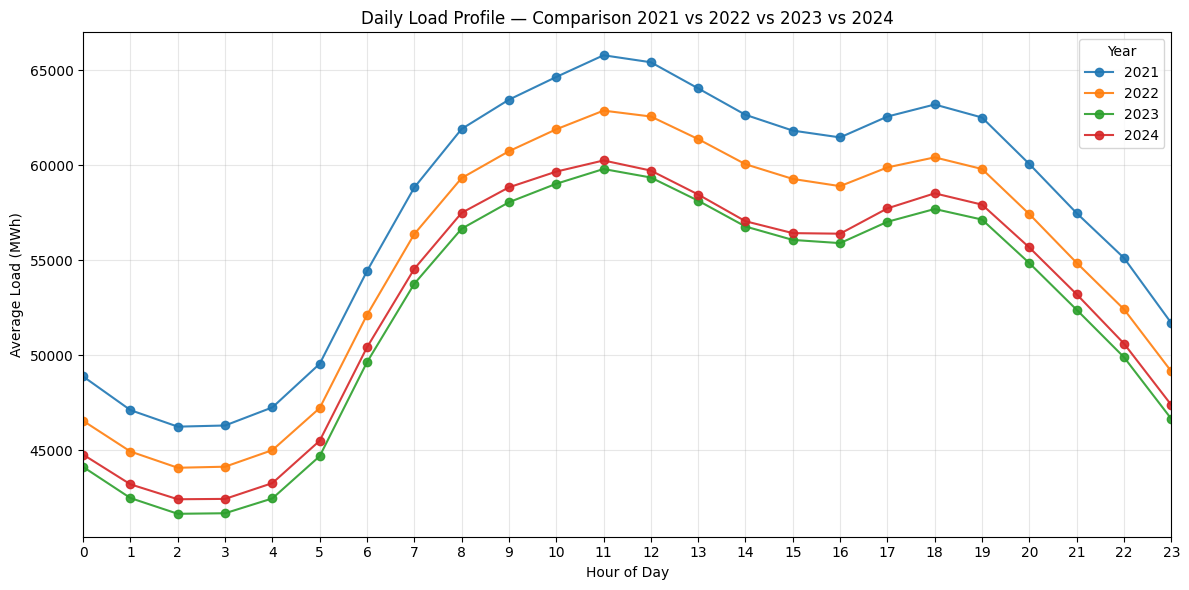

In [11]:
# Daily patterns comparison by year (hours on x-axis 0-23)

# Aggregate mean load by year and hour
df_hourly_yearly = (
    cleaned_df
    .groupby(['year', 'hour'])['load_MWh']
    .mean()
    .reset_index()
    .pivot(index='hour', columns='year', values='load_MWh')
)

# Plot
plt.figure(figsize=(12, 6))
years_to_plot = [2021, 2022, 2023, 2024]

for yr in years_to_plot:
    if yr in df_hourly_yearly.columns:
        plt.plot(
            df_hourly_yearly.index, 
            df_hourly_yearly[yr], 
            marker='o', 
            label=str(yr), 
            alpha=0.9
        )

plt.xlabel('Hour of Day')
plt.ylabel('Average Load (MWh)')
plt.title('Daily Load Profile — Comparison 2021 vs 2022 vs 2023 vs 2024')
plt.grid(alpha=0.3)
plt.legend(title='Year')

# x-axis hours 0–23
plt.xticks(ticks=range(0, 24), labels=[str(h) for h in range(0, 24)], rotation=0)
plt.xlim(0, 23)

plt.tight_layout()
plt.show()


### Key Findings: Daily Load Profile (2021–2024)

- **Stable and consistent intraday pattern across all years**  
  - Demand remains low during night hours.  
  - A sharp morning ramp-up occurs around 6:00, reflecting the start of industrial and commercial activity.  
  - Load peaks between **10:00 and 13:00**, followed by a gradual decline during the evening hours.  

- **2021 exhibits the highest load levels throughout the day**,  
  indicating strong post-pandemic industrial recovery and high overall electricity consumption.  

- **2022 shows a moderate decline** in daytime demand compared to 2021,  
  reflecting the initial effects of the energy crisis and early efficiency measures.  

- **2023 records the lowest consumption across all hours**,  
  driven by sustained energy-saving behavior, high prices, and reduced industrial activity.  

- **2024 shows a slight rebound above 2023**,  
  suggesting a stabilization of demand and gradual recovery under continued efficiency improvements.



## Trend Analysis

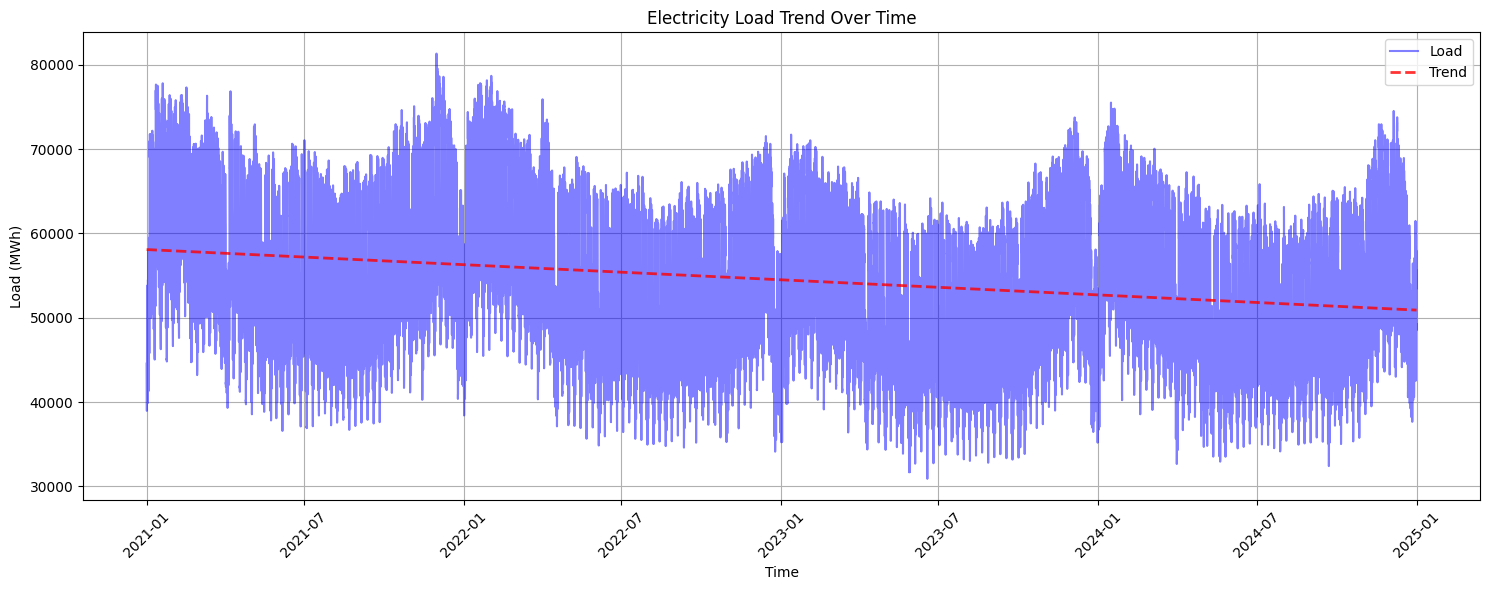


Trend Analysis:
Slope: -0.20 MWh per time unit
R-squared: 0.0469
Standard Error: 0.0049
P-value: 0.0000000000

Significance Test:
The trend is statistically significant (p < 0.05)
We can reject the null hypothesis that there is no trend


In [12]:
# Create the plot
plt.figure(figsize=(15, 6))

# Plot the actual data
plt.plot(cleaned_df["timestamp"], cleaned_df["load_MWh"], alpha=0.5, label='Load', color='blue')

# Calculate and plot trend line
x = np.arange(len(cleaned_df))
z = np.polyfit(x, cleaned_df["load_MWh"], 1)
p = np.poly1d(z)
plt.plot(cleaned_df["timestamp"], p(x), "r--", alpha=0.8, label='Trend', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Load (MWh)")
plt.title("Electricity Load Trend Over Time")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print trend statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(x, cleaned_df["load_MWh"])
print(f"\nTrend Analysis:")
print(f"Slope: {slope:.2f} MWh per time unit")
print(f"R-squared: {r_value**2:.4f}")
print(f"Standard Error: {std_err:.4f}")
print(f"P-value: {p_value:.10f}")
print("\nSignificance Test:")
if p_value < 0.05:
    print("The trend is statistically significant (p < 0.05)")
    print(f"We can reject the null hypothesis that there is no trend")
else:
    print("The trend is not statistically significant (p >= 0.05)")
    print(f"We cannot reject the null hypothesis that there is no trend")

### Key Findings: Electricity Load Trend (2021–2024)

- **Clear downward trend in electricity demand**  
  - The fitted trend line indicates a persistent decrease in average electricity load over the four-year period.

- **Statistically significant negative slope**  
  - Slope: −0.20 MWh per time unit  
  - p-value < 0.001 → the trend is statistically significant.  
  - We reject the null hypothesis that there is no trend.

- **Moderate explanatory power**  
  - R² = 0.0469, meaning the trend explains about 4.7% of total variance.  
  - Although daily and seasonal fluctuations dominate, a structural decline in demand remains evident.

- **Interpretation**  
  - The trend reflects sustained reductions in consumption following the 2022 energy crisis, driven by:  
    - energy-saving behavior and efficiency improvements  
    - partial industrial slowdown  
    - increased renewable generation and electrification efficiency  

- **Seasonality remains the dominant pattern**  
  - Distinct winter peaks and summer troughs persist across all years,  
    indicating that seasonal consumption cycles continue despite the downward trend.



## Summary of Exploratory Data Analysis

This exploratory analysis provides a comprehensive overview of Germany’s electricity load dynamics from 2021 to 2024.  
The dataset reveals strong and consistent seasonal patterns across multiple time scales.  
At the annual level, electricity demand peaks during winter months and drops substantially in summer,  
reflecting heating requirements, daylight variations, and reduced industrial activity.  

Weekly and daily profiles confirm a pronounced weekday–weekend effect,  
with higher commercial and industrial demand on weekdays and lower, flatter curves on weekends.  
Intraday behavior remains stable across all years, characterized by a sharp morning ramp-up,  
a late-morning peak, and a gradual evening decline.

A year-by-year comparison shows that **2021 recorded the highest overall consumption**,  
driven by post-pandemic industrial recovery and pre-crisis demand levels.  
**2022 marked the beginning of a decline**, reflecting the impact of the energy crisis and early efficiency measures.  
**2023 registered the lowest demand**, consistent with continued energy-saving behavior,  
price effects, and reduced industrial output.  
**2024 shows a slight rebound** but remains below pre-crisis levels,  
indicating stabilization under ongoing energy transition and efficiency improvements.

Trend analysis confirms a **statistically significant downward trend** (slope = −0.20 MWh per time unit, R² = 0.0469),  
suggesting a persistent structural decline in electricity demand.  
However, strong seasonal cycles continue to dominate the variation,  
highlighting the importance of incorporating periodic effects in subsequent time-series forecasting models.

